In [2]:
import chess
from game import Game
from mcts import run_mcts
from config import Config
import numpy as np
import gameimage


#from model_v2 import predict_fn
from model import generate_model
import time
import os
from tensorflow.python.compiler.tensorrt import trt_convert as trt
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [4]:
model = tf.keras.models.load_model('checkpoints/keras/checkpoint.model.keras')

2024-01-30 12:37:26.198033: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6191 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5


In [2]:
model = tf.saved_model.load("checkpoints/trt/26-01-2024_17:05:15/saved_model")
trt_func = model.signatures['serving_default']

2024-01-26 18:06:52.565949: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5598 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5


In [185]:
config = Config()
# Scholar's mate but for black
game = Game(config=config)
game.make_move("e2e4")
game.make_move("e7e5")
game.make_move("f1c4")
game.make_move("b8c6")
game.make_move("d1h5")
game.make_move("g8f6")
#game.make_move("h5f7")

t1 = time.time()
move, root = run_mcts(game, 
                trt_func,
                300,
                0,
                )
t2 = time.time()
print(t2-t1)
print(move)

2.7759809494018555
g1e2


In [186]:
s = 0
for move, child in root.children.items():
    print(move, child.N, child.Q)
    s += child.N
print(s)

h5h7 0 0
h5f7 0 0
h5h6 2 -0.002385223750025034
h5g6 2 -0.002383182290941477
h5g5 4 0.002109069610014558
h5f5 1 -0.011367551051080227
h5e5 1 -0.007013215683400631
h5h4 2 -0.0023841061629354954
h5g4 0 0
h5h3 8 0.0027020936249755323
h5f3 0 0
h5e2 0 0
h5d1 1 -0.01136802788823843
c4f7 1 -0.006980225909501314
c4e6 0 0
c4a6 33 -0.0029941195706752214
c4d5 1 -0.011371484957635403
c4b5 5 0.003004268556833267
c4d3 24 -0.0016247265545340877
c4b3 1 -0.01136576384305954
c4e2 1 -0.011367849074304104
c4f1 5 0.003005162812769413
g1h3 1 -0.011367789469659328
g1f3 6 0.0036023294863601527
g1e2 47 -0.0027332578765902112
e1e2 7 0.0019725922362080644
e1f1 7 0.001972549661461796
e1d1 0 0
b1c3 2 -0.0023870267905294895
b1a3 8 0.0028002701001241803
h2h3 10 0.0040050559677183625
g2g3 5 0.0038809233345091345
f2f3 15 0.0023203348740935326
d2d3 6 0.004323080492516358
c2c3 4 0.003197221434675157
b2b3 6 0.0043349960663666325
a2a3 34 -0.0013998167260604747
h2h4 1 -0.006995900999754667
g2g4 8 0.003254506387747824
f2f4 3

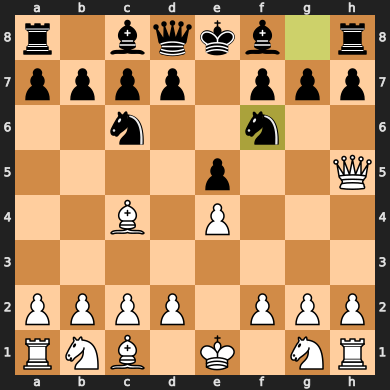

In [8]:
game.board

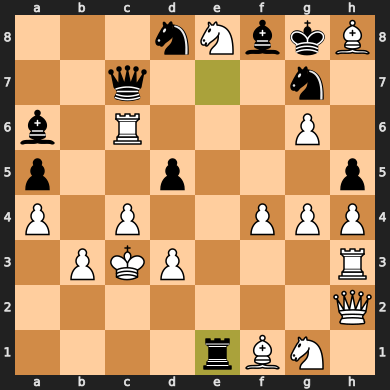

In [8]:
game.board

In [3]:
config = Config()
player = chess.WHITE
game = Game(config=config)

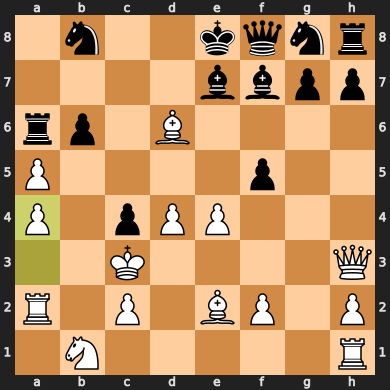

In [48]:
if not game.to_play() == player:
    # make random move
    move = np.random.choice(game.legal_moves())
    game.make_move(move)
else:
    move, _ = run_mcts(
        game, 
        trt_func,
        config.num_mcts_sims[1],
        0,
        )
    game.make_move(move)
if game.terminal():
    print(game.outcome_str)
game.board


In [56]:
#Batch predict without overhead
images = np.zeros((219, 8, 8, 119), dtype=np.float32)
for i in range(100):
    image = Game.make_image_sample(config).astype(np.float32)
    images[i, :, :, :] = image
images_tf = tf.convert_to_tensor(images, dtype=tf.float32)

t1 = time.time()
preds1 = trt_func(images_tf)
t2 = time.time()
print(t2-t1)

KeyboardInterrupt: 

In [ ]:
values, policies = preds1["value_head"].numpy(), preds1["policy_head"].numpy()
print(values[0])
print(policies[0])

In [ ]:
t1 = time.time()
preds2 = []
for _ in range(100):
    image = np.array(Game.make_image_sample(config).astype(np.float32))
    tf_image = tf.convert_to_tensor(tf.expand_dims(image, axis=0))
    pred = trt_func(tf_image)
    preds2.append(pred)
t2 = time.time()
print(t2-t1)

In [ ]:
board = game.board
board.legal_moves.to_san()

In [ ]:
for i in range(100):
    # Compare if same
    #print(preds1["value_head"][1])
    #print(preds2[1]["value_head"][0])
    print(np.allclose(preds1["value_head"][i], preds2[i]["value_head"][0]))
    print(np.allclose(preds1["policy_head"][i], preds2[i]["policy_head"][0]))

In [ ]:
print(np.allclose(preds1["value_head"][0], preds1["value_head"][101]))
print(np.allclose(preds1["policy_head"][0], preds1["policy_head"][101]))

In [ ]:
import chess
from game import Game
from mcts import run_mcts
from config import Config
import numpy as np
import gameimage
from config import Config
import time

In [ ]:
config = Config()
game = Game(config=config)
#t1 = time.time()
#image = game.make_image()
#t2 = time.time()
#print(t2-t1)
times = []
for _ in range(5120):
    t1 = time.time()
    game2 = game.clone()
    game2.make_move("e2e4")
    image = game2.make_image()
    t2 = time.time()
    times.append(t2-t1)
print(np.mean(times))

In [ ]:
times = []
for _ in range(5120):
    t1 = time.time()
    image = gameimage.update_image(image, game, "e2e4")
    t2 = time.time()
    times.append(t2-t1)
print(np.mean(times))

In [ ]:
8*14

In [ ]:
model = generate_model(config)
images = [Game.make_image_sample(config).astype(np.float32) for _ in range(100)]
images = tf.constant(images)


t1 = time.time()
preds = model.predict_on_batch(images)
t2 = time.time()
print(t2-t1)

In [ ]:
game.board

In [ ]:
predict_fn(trt_func, Game.make_image_sample(config).astype(np.float32))

In [ ]:
game = Game(config=config)
player = chess.WHITE
while not game.terminal() and game.history_len < 256:
    if game.to_play() == player:
        move, _ = run_mcts(game, config, trt_func, True)
        game.make_move(move)
    else:
        # Make random move
        moves = game.legal_moves()
        move = np.random.choice(moves)
        game.make_move(move)
game.board


In [ ]:
game = Game(config=config)
game.make_move("e2e4")
game.make_move("e7e5")
game.make_move("a2a3")
game.make_move("b8c6")
game.make_move("b2b3")
game.make_move("f8c5")
game.make_move("h2h3")
game.make_move("d8h4")
game.make_move("h1h2")
move, root = run_mcts(game, config, trt_func, True)
for m, child in root.children.items():
    if child.visits_count > 0:
        print(m, child.value_sum, child.visits_count)
print(move)
game.board

In [ ]:
import actionspace as asp
sum_visits = sum(child.visits_count for child in root.children.values())
child_visits = np.zeros(config.num_actions)
for uci_move, child in root.children.items():
    action = asp.uci_to_action(uci_move, root.to_play)
    child_visits[action] = child.visits_count / sum_visits
print(np.argmax(child_visits))
print(child_visits[np.argmax(child_visits)])
print(f"move {move} idx {asp.uci_to_action(move, root.to_play)} str {asp.uci_to_actionstr(move, root.to_play)}")

In [ ]:
value, policy_logits = predict_fn(trt_func, game.make_image(-1).astype(np.float32))
print(value)
print(policy_logits)
print(policy_logits[asp.uci_to_action(move, root.to_play)])

In [ ]:
game_after = game.clone()
game_after.make_move(move)
print(game_after.terminal())
player_on_turn = [chess.WHITE if i % 2 == 0 else chess.BLACK for i in range(game_after.history_len)]
terminal_values = [game_after.terminal_value(player) for player in player_on_turn]
print("Black") if player_on_turn[-1] == chess.BLACK else print("White")
print(terminal_values[-1])


In [ ]:
game_after.board

In [ ]:
visit_counts = [(child.visits_count, move) for move, child in root.children.items()]
print(visit_counts)
counts_np = np.asarray([count for count, _ in visit_counts])
print(counts_np)
choice = np.random.default_rng().choice(np.argwhere(counts_np == np.max(counts_np)).flatten())
print(choice)
_, action = visit_counts[choice]
print(action)

In [ ]:
neki = {'a': 5, 'b': 6}
a = np.sum(list(neki.values()), dtype=np.float32)
print(a)

In [ ]:
image = game.make_image(-1).astype('float32')
image = tf.expand_dims(image, axis=0)
image = tf.convert_to_tensor(image, dtype=tf.float32)
preds = trt_func(image)
policy_logits = preds["policy_head"].numpy()[0]
value = preds["value_head"].numpy()[0]


In [ ]:
value

In [ ]:
#visit_counts = [(child.visits_count, move) for move, child in node.children.items()]

def softmax(x: np.ndarray) -> np.ndarray:
    return np.exp(x) / np.sum(np.exp(x), axis=0)

visit_counts = [(5,"nf3"), (10, "e4"), (15 ,"d4")]
p = softmax(np.asarray(visit_counts).T[0].astype(int))
v = np.random.choice(len(visit_counts), p=p)
print(visit_counts[v][0])
print(visit_counts[v][1])

In [ ]:
from model_v2 import predict_fn
image = Game.make_image_sample(config).astype(np.float32)
value, logits = predict_fn(trt_func, image)

In [ ]:
value[0]

In [ ]:
import numpy as np
root_dirichlet_alpha = 0.3
moves = np.arange(10)
noise = np.random.gamma(root_dirichlet_alpha, 1, len(moves))
print(noise)

In [ ]:
np.random.default_rng().gamma(root_dirichlet_alpha, 1, 10)

In [ ]:
# Choose one of the maximum values in counts at random
#counts = [(1, "a"), (2, ""), 5, 7, 4, 7, 6, 5, 0, 0, -7]
counts = [(1, "a"), (2, "b"), (5, "c"), (7, "d"), (4, "e"), (7, "f"), (6, "g"), (5, "h"), (0, "i"), (0, "j"), (7, "k")]
counts_np = np.array([c[0] for c in counts])
choice = np.random.default_rng().choice(np.argwhere(counts_np == np.max(counts_np)).flatten())
print(choice)
print(counts[choice])

In [ ]:
import numpy as np

In [ ]:
p = 0.25
r = np.random.default_rng().random()
r

In [ ]:
import time
import math

t1 = time.time()
a = math.sqrt(2)
t2 = time.time()
print(t2 - t1)

t1 = time.time()
a = 2**0.5
t2 = time.time()
print(t2 - t1)

In [ ]:
import numpy as np
p = [0.4, 0.2, 0.3, 0.1]
p = np.exp(p)
s = np.sum(p)
for i in p:
    print(i/s)

In [ ]:
neki = {
    "polcs": [0.1, 0.3, 0.2, 0.4]
}
for i, pol in enumerate(neki["polcs"]):
    neki["polcs"][i] = pol + 1

neki["polcs"]

In [13]:
import actionspace as asp
from game import Game
from config import Config
import numpy as np

config = Config()
buffer = []
for _ in range(100):
    rnd = np.random.randint(0, 26)
    images = [Game.make_image_sample(config).astype(np.float32) for _ in range(rnd)]
    values = np.random.rand(rnd)
    buffer.append([images, (values, None)])




In [17]:
lens = [len(b[0]) for b in buffer]

In [18]:
lens

[18,
 1,
 2,
 0,
 11,
 5,
 1,
 14,
 5,
 20,
 7,
 4,
 13,
 20,
 8,
 11,
 12,
 7,
 10,
 18,
 12,
 11,
 25,
 16,
 8,
 11,
 0,
 14,
 23,
 7,
 9,
 11,
 16,
 16,
 4,
 1,
 10,
 14,
 12,
 3,
 6,
 14,
 8,
 22,
 7,
 4,
 25,
 4,
 3,
 15,
 3,
 10,
 16,
 22,
 22,
 0,
 16,
 11,
 22,
 20,
 6,
 7,
 0,
 25,
 9,
 9,
 7,
 11,
 14,
 14,
 15,
 5,
 23,
 15,
 9,
 16,
 1,
 16,
 16,
 9,
 10,
 3,
 0,
 0,
 13,
 8,
 1,
 22,
 18,
 15,
 15,
 4,
 2,
 6,
 9,
 17,
 6,
 17,
 13,
 8]

In [16]:
len(lens)

100

In [12]:
# random integer between 0 and 25
np.random.randint(0, 26)

5

In [1]:
import numpy as np

buffer = []
for i in range(100):
    # random integer between 0 and 25
    rnd = np.random.randint(0, 26)
    images = []
    search_statistics = []
    values = []
    for _ in range(rnd):
        images.append(np.random.rand(8, 8, 119))
        search_statistics.append(np.random.rand(4672))
        values.append(np.random.randint(-1, 1))
    buffer.append([images, (values, search_statistics)])



In [10]:
batch_size = 8
game_lengths = [len(buffer[game][0]) for game in range(len(buffer))]
game_lengths_sum = sum(game_lengths)
selected_games = np.random.choice(len(buffer), batch_size, p=[game_length / game_lengths_sum for game_length in game_lengths])
positions = np.array([np.random.randint(0, game_lengths[selected_game]) for selected_game in selected_games])

In [11]:
selected_games

array([99, 68, 37, 71, 26, 37,  5, 73])

In [12]:
positions

array([10, 12,  3,  8, 11, 11,  2, 10])

In [13]:
# images
x = np.array([buffer[selected_game][0][position] for selected_game, position in zip(selected_games, positions)])
x.shape

(8, 8, 8, 119)

In [14]:
# values
y1 = np.array([buffer[selected_game][1][0][position] for selected_game, position in zip(selected_games, positions)])
y1.shape

(8,)

In [15]:
# search_statistics
y2 = np.array([buffer[selected_game][1][1][position] for selected_game, position in zip(selected_games, positions)])
y2.shape

(8, 4672)

In [3]:
buffer = [1, 2, 3, 4, 5, 6]
idcs = [1, 3, 5]
neki = buffer[idcs]
neki

SyntaxError: invalid syntax. Perhaps you forgot a comma? (641963332.py, line 3)

In [6]:
import numpy as np
rng = np.random.default_rng()
# random integer between 0 and 25
rnd = rng.integers(0, 26)
rnd

20

In [82]:
def neki(buf):
    tmp = buf[:]
    tmp.append(5)
    print(tmp)

buf = [1, 2, 3, 4]
neki(buf)
buf

[1, 2, 3, 4, 5]


[1, 2, 3, 4]

In [ ]:
def sample_buffer(buffer: [], batch_size: int):
    buffer_length = len(buffer)
    rng = np.random.default_rng()

    game_lengths = [len(buffer[game][0]) for game in range(buffer_length)]
    game_lengths_sum = sum(game_lengths)
    selected_games = rng.choice(buffer_length, batch_size, p=[game_length / game_lengths_sum for game_length in game_lengths])
    positions = np.array([rng.integers(0, game_lengths[selected_game]) for selected_game in selected_games])
    images = np.array([buffer[selected_game][0][position] for selected_game, position in zip(selected_games, positions)])
    terminal_values = np.array([buffer[selected_game][1][0][position] for selected_game, position in zip(selected_games, positions)])
    search_statistics = np.array([buffer[selected_game][1][1][position] for selected_game, position in zip(selected_games, positions)])
    return images, (terminal_values, search_statistics)

In [1]:
import actionspace

In [5]:
from pympler import asizeof
asizeof.asizeof(actionspace) / 1024 / 1024

0.10774993896484375

In [1]:
from threading import Thread
import numpy as np
import time
from config import Config
from game import Game
from mcts_v2 import run_mcts

config = Config()

num_threads = 10
threads = []

def fake_model(_):
    return {
        "value_head": [[0.5]], 
        "policy_head": [np.ones(4672).tolist()]
    }

def neki(id: int):
    game = Game(config=config)
    t1 = time.time()
    _, _ = move, root = run_mcts(
            game=game,
            network=fake_model,
            num_simulations=50,
            num_sampling_moves=30, # Makes sure games are diverse (the picked move has no direct influence on the search probablities which are used for training)
            add_noise=True, # Quick searches have disabled exploration functions
            CPUCT=None # None for full search (uses AZ exploration C calculation), 1.0 for quick search
        )
    t2 = time.time()
    print(f"Thread {id} time: {t2-t1}")

for i in range(num_threads):
    t = Thread(target=neki, args=(i,))
    t.start()
    threads.append(t)

for t in threads:
    t.join()

2024-01-26 18:04:40.758463: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-26 18:04:50.783404: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5446 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5


Thread 6 time: 71.89691638946533
Thread 8 time: 71.90326571464539
Thread 7 time: 71.96778321266174
Thread 0 time: 72.71083927154541
Thread 9 time: 72.78078532218933
Thread 4 time: 73.23053693771362
Thread 5 time: 72.95796656608582
Thread 2 time: 73.81265044212341
Thread 3 time: 73.81555271148682
Thread 1 time: 74.04366445541382


In [7]:
neki = np.array([1, 2, 3, 4, 5])

In [9]:
neki.tolist()

[1, 2, 3, 4, 5]

In [5]:
from model_v2 import predict_fn

In [17]:
config = Config()
times = []
image = Game.make_image_sample(config).astype(np.float32)
for i in range(100):
    t1 = time.time()
    for _ in range(10):      
        image_tf = tf.expand_dims(image, axis=0)
        image_tf = tf.convert_to_tensor(image, dtype=tf.float32)
        predictions = trt_func(image_tf)
    t2 = time.time()
    times.append(t2-t1)
print((t2-t1)/100)

0.06091785430908203


In [19]:
images = []
for _ in range(10):
    image = Game.make_image_sample(config).astype(np.float32)
    images.append(image)
images = np.array(images)

times = []
for i in range(100):
    t1 = time.time()
    images_tf = tf.convert_to_tensor(images, dtype=tf.float32)
    predictions = predict_fn(trt_func, images_tf)
    t2 = time.time()
    times.append(t2-t1)
t1 = time.time()

prediction = trt_func(images)
t2 = time.time()
print(t2-t1)

0.018840312957763672
